# Orbit Propagator Tutorial

This jupyter notebook is a tool to help you use a high fidelity propagator for the AI Challenge. The propagator is written using a python wrapper of Orekit version 12. These instructions below will ensure you have the right setup.
1. To download and install orekit and other dependencies, follow the instructions in `README.md`. 
2. Ensure that `orekit-data.zip` is in the same directory as this file. If not, download it using `pip install git+https://gitlab.orekit.org/orekit/orekit-data.git` in the miniconda environment
3. Ensure there is a `Space-Weather-Data` folder in this directory. In it, there should be `SOLFSMY.TXT` and `DTCFILE.TXT`. These files are used by the JB2008 atmospheric model. You will not need them if you are implementing your own custom atmosphere model, but this file will not run initally without them.

Now you are equipped to use the propagator. Run all the cells to get a sense of what the propagator outputs looks like. Instructions are included between the code cells to help you use your own custom atmosphere model.

## Imports and Orekit Setup

In [11]:
import orekit
from orekit.pyhelpers import setup_orekit_curdir, absolutedate_to_datetime

from org.orekit.orbits import KeplerianOrbit, EquinoctialOrbit, PositionAngleType, OrbitType, CartesianOrbit
from org.orekit.frames import FramesFactory, LOFType, Frame
from org.orekit.time import AbsoluteDate, TimeScalesFactory
from org.orekit.utils import Constants, PVCoordinates
from org.orekit.propagation.numerical import NumericalPropagator
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.propagation import SpacecraftState
from org.orekit.bodies import OneAxisEllipsoid, CelestialBodyFactory, CelestialBody
from org.orekit.utils import IERSConventions
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel, ThirdBodyAttraction, OceanTides, SolidTides
from orekit import JArray_double, JArray
from java.util import ArrayList

from org.orekit.forces.radiation import SolarRadiationPressure, IsotropicRadiationSingleCoefficient, RadiationSensitive
from org.orekit.models.earth.atmosphere.data import CssiSpaceWeatherData, JB2008SpaceEnvironmentData
from org.orekit.forces.drag import IsotropicDrag, DragForce
from org.orekit.models.earth.atmosphere import DTM2000, HarrisPriester, JB2008, NRLMSISE00, Atmosphere, SimpleExponentialAtmosphere, PythonAtmosphere

from org.hipparchus.geometry.euclidean.threed import Vector3D

from math import radians, degrees, pi
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import time
import matplotlib.ticker as ticker
plt.rcParams.update({'font.size': 12})

vm = orekit.initVM()
setup_orekit_curdir()

## Custom Atmosphere

This custom atmosphere class is where you can input your own atmospheric models. Currently, the model initializes a JB2008 model and outputs densities based off of that. To input your own atmosphere model, edit the `__init__()` function to import/initialize your own density model. Then edit the `getDensity()` function to output density values based off of your model. You should not need to touch the `getVelocity()` function. The frame of reference for `getDensity()` and `getVelocity()` is the EME2000 (inertial).

In [12]:
class CustomAtmosphere(PythonAtmosphere):
    """
    CustomAtmosphere is a custom implementation of the PythonAtmosphere class
    that uses the JB2008 atmospheric model to compute atmospheric density and
    velocity.

    Attributes:
        atm (JB2008): An instance of the JB2008 atmospheric model.
        earth (Body): The central body (Earth) for the atmospheric model.

    Methods:
        getDensity(date: AbsoluteDate, position: Vector3D, frame: Frame) -> float:
            Computes the atmospheric density at a given date, position, and frame.
        
        getVelocity(date: AbsoluteDate, position: Vector3D, frame: Frame) -> Vector3D:
            Computes the inertial velocity of atmosphere molecules at a given date,
            position, and frame. By default, the atmosphere is assumed to have a null
            velocity in the central body frame.
    """
    def __init__(self, cswl, sun, earth):
        super().__init__()
        # TODO for partcipants: initialize your atmospheric density model here
        self.atm = JB2008(cswl, sun, earth)
        self.earth = earth
    def getDensity(self, date: AbsoluteDate, position: Vector3D, frame: Frame):
        # TODO for partcipants: get the density from your model given date, position, and frame
        return self.atm.getDensity(date, position, frame)
    def getVelocity(self, date: AbsoluteDate, position: Vector3D, frame: Frame):
        '''
        Get the inertial velocity of atmosphere molecules.
        By default, atmosphere is supposed to have a null
        velocity in the central body frame.</p>
        '''
        # get the transform from body frame to the inertial frame
        bodyToFrame = self.earth.getBodyFrame().getKinematicTransformTo(frame, date)
        # Inverse transform the position to the body frame
        posInBody = bodyToFrame.getStaticInverse().transformPosition(position)
        # Create PVCoordinates object assuming zero velocity in body frame
        pv_body = PVCoordinates(posInBody, Vector3D.ZERO)
        # Transform the position/velocity (PV) coordinates to the given frame
        pvFrame = bodyToFrame.transformOnlyPV(pv_body)
        # Return the velocity in the current frame
        return pvFrame.getVelocity()
  


# Constants and Basics

In [13]:

r_Earth = Constants.IERS2010_EARTH_EQUATORIAL_RADIUS #m
itrf    = FramesFactory.getITRF(IERSConventions.IERS_2010, True) # International Terrestrial Reference Frame, earth fixed
inertialFrame = FramesFactory.getEME2000()
earth = OneAxisEllipsoid(r_Earth,
                         Constants.IERS2010_EARTH_FLATTENING,
                         itrf)
mu = Constants.IERS2010_EARTH_MU #m^3/s^2
utc = TimeScalesFactory.getUTC()



## Propagator Function

This function propagates the orbit by taking in an initial state and using a numerical propagator which takes into account drag force, gravity, solar radiation, and tides. It returns a tuple containing the state at each iteration and the atmospheric density at each iteration.
You should not need to edit this function unless you want to edit the parameters in the `CustomAtmosphere` constructor.

In [14]:

def prop_orbit(initial_orbit, duration, step, CustomAtmosphereClass):
    """
    Propagates the orbit of a satellite over a given duration using a high-fidelity numerical propagator.
    Parameters:
    initial_orbit (Orbit): The initial orbit of the satellite.
    duration (float): The duration for which to propagate the orbit, in seconds.
    CustomAtmosphereClass (class): A custom atmosphere model class to be used for drag force calculations.
    Returns:
    tuple: A tuple containing:
        - states (list of SpacecraftState): The list of spacecraft states at each propagation step.
        - densities (list of float): The list of atmospheric densities at each spacecraft state.
    The function performs the following steps:
    1. Initializes the orbit parameters and spacecraft properties.
    2. Sets up the time span for propagation.
    3. Configures the numerical integrator and propagator.
    4. Adds force models to the propagator.
    5. Propagates the orbit over the specified duration.
    7. Plots the satellite trajectory in 3D.
    8. Computes atmospheric densities at each propagated state.
    """

    dur = duration # propagation duration time [s]
    satellite_mass = 260.0
    crossSection = 3.2 * 1.6 # m^2
    srpArea = 30.0 # m^2

    degree = 70
    torder = 70
    dragCoeff = 2.2
    cr = 1.0

    utc = TimeScalesFactory.getUTC()
    epochDate = AbsoluteDate(2022, 1, 1, 0, 0, 00.000, utc)
    initialDate = epochDate
    start_time = initialDate
    tspan = [start_time.shiftedBy(float(dt)) for dt in np.linspace(0, duration, int(duration / step))]

    minStep = 1e-6
    maxstep = 100.0
    initStep = 1.0
    positionTolerance = 1e-4

    sun = CelestialBodyFactory.getSun()
    moon = CelestialBodyFactory.getMoon()

    satmodel = IsotropicDrag(crossSection, dragCoeff) # Cross sectional area and the drag coefficient

    initialOrbit = initial_orbit
    orbitType = initialOrbit.getType()
    initialState = SpacecraftState(initialOrbit, satellite_mass)
    tol = NumericalPropagator.tolerances(positionTolerance, initialOrbit, orbitType)

    integrator = DormandPrince853Integrator(minStep, maxstep, JArray_double.cast_(tol[0]), JArray_double.cast_(tol[1]))
    integrator.setInitialStepSize(initStep)

    propagator_num = NumericalPropagator(integrator)
    propagator_num.setOrbitType(orbitType)
    propagator_num.setInitialState(initialState)

    # Add Solar Radiation Pressure
    spacecraft = IsotropicRadiationSingleCoefficient(srpArea, cr)
    srpProvider = SolarRadiationPressure(sun, earth, spacecraft)
    propagator_num.addForceModel(srpProvider)

    # Add Gravity Force
    gravityProvider = GravityFieldFactory.getConstantNormalizedProvider(degree, torder, initialDate)
    gravityForce = HolmesFeatherstoneAttractionModel(earth.getBodyFrame(), gravityProvider)
    propagator_num.addForceModel(gravityForce)

    # Add Solid Tides
    solidTidesBodies = ArrayList().of_(CelestialBody)
    solidTidesBodies.add(sun)
    solidTidesBodies.add(moon)
    solidTidesBodies = solidTidesBodies.toArray()
    solidTides = SolidTides(earth.getBodyFrame(), 
                            gravityProvider.getAe(), gravityProvider.getMu(),
                            gravityProvider.getTideSystem(), 
                            IERSConventions.IERS_2010,
                            TimeScalesFactory.getUT1(IERSConventions.IERS_2010, True), 
                            solidTidesBodies)
    propagator_num.addForceModel(solidTides)

    # Add Third Body Attractions
    propagator_num.addForceModel(ThirdBodyAttraction(sun))
    propagator_num.addForceModel(ThirdBodyAttraction(moon)) 

    # Add Custom Drag Force
    cswl = JB2008SpaceEnvironmentData("SOLFSMY.TXT", "DTCFILE.TXT")
    atmosphere = CustomAtmosphereClass(cswl, sun, earth)
    dragForce = DragForce(atmosphere, satmodel)
    propagator_num.addForceModel(dragForce)

    states = [initialState]
    tic = time.time()
    states = [propagator_num.propagate(tt)  for tt in tspan]
    toc = time.time()

    posvel = [state.getPVCoordinates() for state in states]
    poss = [state.getPosition() for state in posvel]
    vels = [state.getVelocity() for state in posvel]
    px = [pos.getX() * 1e-3 for pos in poss]
    py = [pos.getY() * 1e-3 for pos in poss]
    pz = [pos.getZ() * 1e-3 for pos in poss]
    vx = [vel.getX() * 1e-3 for vel in vels]
    vy = [vel.getY() * 1e-3 for vel in vels]
    vz = [vel.getZ() * 1e-3 for vel in vels]
    stat_list = [dur, toc - tic, px[-1], py[-1], pz[-1], vx[-1], vy[-1], vz[-1], step]
    print("Time interval [s]:", stat_list[0])
    print("Time step [s]:", stat_list[8])
    print("CPU time [s]:", stat_list[1])
    print("Final Pos [km]:", np.linalg.norm([px[-1], py[-1], pz[-1]]))
    print("Final Vel [km]:", np.linalg.norm([vx[-1], vy[-1], vz[-1]]))

    # Plot the satellite trajectory
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(px, py, pz, label='Trajectory')
    
    # plot earth
    phi = np.linspace(-np.pi, np.pi, 100)
    theta = np.linspace(-np.pi/2, np.pi/2, 50)
    X_Earth = r_Earth*1e-3 * np.outer(np.cos(phi), np.cos(theta)).T
    Y_Earth = r_Earth*1e-3 * np.outer(np.sin(phi), np.cos(theta)).T
    Z_Earth = r_Earth*1e-3 * np.outer(np.ones(np.size(phi)), np.sin(theta)).T
    ax.plot_surface(X_Earth, Y_Earth, Z_Earth, cmap='binary', alpha=0.35, antialiased=False, zorder = 1)
    
    ax.set_xlabel('X [km]')
    ax.set_ylabel('Y [km]')
    ax.set_zlabel('Z [km]')
    ax.set_aspect('equal', adjustable='box')
    ax.set_title('Satellite Trajectory')
    ax.legend()
    plt.show()

    densities = []
    for state in states:
        density = atmosphere.getDensity(state.getDate(), state.getPVCoordinates().getPosition(), state.getFrame())
        densities.append(density)
    
    return states, densities



## Call Propagator Function
This code calls the `prop_orbit()` using an initial orbit and propagation duration. Edit the `initialOrbit`, `date`, `duration`, and `step` fields to your liking.

Time interval [s]: 86400.0
Time step [s]: 600.0
CPU time [s]: 4.544455051422119
Final Pos [km]: 6865.665041136236
Final Vel [km]: 7.623813506042979


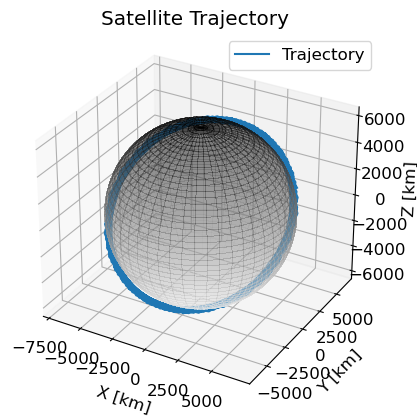

In [15]:
def __main__():

    rp0 = r_Earth + 400 * 1e3 # perigee radius (m)
    ra0 = r_Earth + 600 * 1e3 # apogee radius (m)
    deg = pi / 180
    a0 = (rp0 + ra0) / 2 # semi-major axis (m)
    e0 = (ra0 - rp0) / (ra0 + rp0) # eccentricity 
    w0 = 30 * deg # perigee argument (rad)
    i0 = 45 * deg # inclination (rad)
    ra0 = 0 * deg # right ascension of ascending node (rad)
    M0 = 0 * deg # anomaly

    date = AbsoluteDate(2022, 1, 1, 0, 0, 00.000, TimeScalesFactory.getUTC()) # date of orbit parameters

    initialOrbit = KeplerianOrbit(a0, e0, i0, w0, ra0, M0, PositionAngleType.TRUE, inertialFrame, date, mu)

    duration = 1 * 86400.0 # 1 day in seconds

    secs = 60.0
    mins = 10
    step = secs * mins # propagation step size [s]

    states, densities = prop_orbit(initialOrbit, duration, step, CustomAtmosphere)

if __name__ == "__main__":
    __main__()